# SELECCIÓN DE MODELO 

## 1. OBJETIVO: Predecir el retorno acumulado por hacer staking de Eth en Lido a 7 días.

### MODELO: XGBOOST para Regresión

### Target: retorno acumulado a 7 días

### 1. Cargar datos

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset 
df = pd.read_csv('df_staking.csv')

### 2. Definir features (X) y targets (y)

In [13]:
feature_cols = [
    'apr_pct',
    'apr_lag_1','apr_lag_3','apr_lag_7','apr_lag_14','apr_lag_30','apr_lag_60',
    'apr_roll_std_7','apr_roll_std_14','apr_roll_std_30','apr_roll_std_60',
    'quarter','day_of_year','days_since_start',    # day of the year opcional, probar tambien con month
    'past_7d_return','past_14d_return','past_30d_return','past_60d_return'
]

X = df[feature_cols]
y = df['target_7d_return_pct']


print("Features:", X.columns.tolist())
print("Shape X:", X.shape, "Shape y:", y.shape)

Features: ['apr_pct', 'apr_lag_1', 'apr_lag_3', 'apr_lag_7', 'apr_lag_14', 'apr_lag_30', 'apr_lag_60', 'apr_roll_std_7', 'apr_roll_std_14', 'apr_roll_std_30', 'apr_roll_std_60', 'quarter', 'day_of_year', 'days_since_start', 'past_7d_return', 'past_14d_return', 'past_30d_return', 'past_60d_return']
Shape X: (1762, 18) Shape y: (1762,)


### 3. Train Test Split Temporal

In [14]:
#ajustar train test split: agregando un horizonte temporal
h = 7
split_idx  = int(len(df) * 0.8)
split_date = df['date'].iloc[split_idx]

X = df[feature_cols]
y = df['target_7d_return_pct'] 
train_mask = df['date'] <= split_date
test_mask  = df['date'] > split_date

# clave: recortar las últimas h filas del train (su y usa futuro)
train_idx = df.index[train_mask][:-h]

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

print(f"split_date: {split_date}")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

split_date: 2024-12-09
Train: 1403, Test: 352


### 4. Crear y entrenar modelo XGBoost 

In [15]:
import xgboost as xgb

In [16]:
# Crear modelo XGBoost para regresión

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### 5. Evaluación inicial en train y test:


--- Train Metrics ---
RMSE: 0.00046693147648462174
MAE: 0.0003367992841021591
R2: 0.9996917480815639

--- Test Metrics ---
RMSE: 0.006029772814322773
MAE: 0.005701882644640831
R2: -8.543987780388415


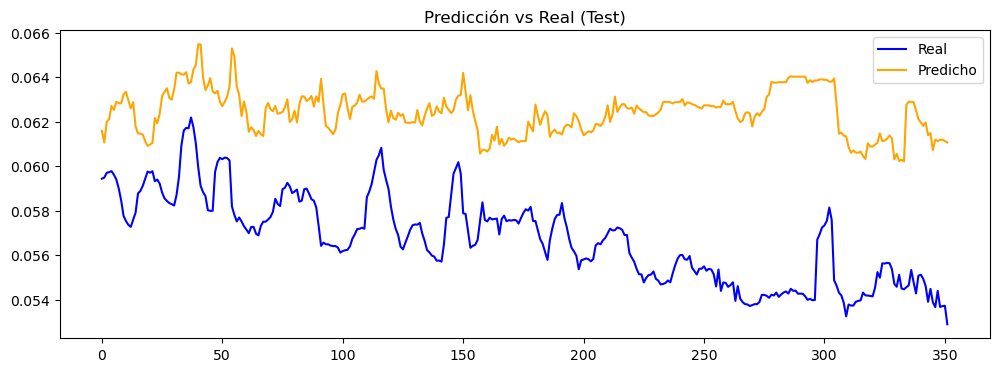

In [17]:
def evaluar_modelo(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # RMSE manual
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print("\n--- Train Metrics ---")
    print("RMSE:", rmse_train)
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("R2:", r2_score(y_train, y_pred_train))
    
    print("\n--- Test Metrics ---")
    print("RMSE:", rmse_test)
    print("MAE:", mean_absolute_error(y_test, y_pred_test))
    print("R2:", r2_score(y_test, y_pred_test))
    
    # Graficar predicción vs real
    plt.figure(figsize=(12,4))
    plt.plot(y_test.values, label='Real', color='blue')
    plt.plot(y_pred_test, label='Predicho', color='orange')
    plt.title("Predicción vs Real (Test)")
    plt.legend()
    plt.show()

evaluar_modelo(model, X_train, y_train, X_test, y_test)  

### 4. Escalado de features

In [18]:
# XGBoost funciona mejor cuando las variables están en rangos parecidos, evita que unas columnas “manden” más que otras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled  = scaler.transform(X_test)

### 5. GridSearch con TimeSeriesSplit (Validación Cruzada temporal)

In [19]:
model_2 = XGBRegressor(random_state=42)  # aún sin hiperparámetros ajustados

# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [1000, 1500, 2000],        # número de árboles que se entrenan
    'learning_rate': [0.005, 0.01, 0.02, 0.05],      # qué tan rápido el modelo ajusta el error. Valores pequeños = entrenamiento más lento, pero más preciso.
    'max_depth': [3,5,7],                        # profundidad máxima de cada árbol. Árboles muy profundos → riesgo de sobreajuste.
    'subsample': [0.7,0.8,0.9],                    # porcentaje de muestras usadas para entrenar cada árbol (reduce overfitting).
    'colsample_bytree': [0.8,0.9, 1.0]              # porcentaje de features usadas para cada árbol (también ayuda a generalizar).
}

# Divide el train en 5 folds, respetando el orden temporal
tscv = TimeSeriesSplit(n_splits=5)   # Fold 1: pasado → futuro / Fold 2: más pasado → más futuro / Fold 3: ...

# Prueba muchas combinaciones de XGBoost pero respetando el tiempo
grid_search = GridSearchCV(
    estimator=model_2,
    param_grid=param_grid,
    cv=tscv,                             # usar validación cruzada temporal
    scoring='neg_mean_squared_error',    # métrica para evaluar cada combinación.XGBoost busca minimizar el MSE, por eso se usa el negativo.
    verbose=2,                           # muestra detalles del progreso
    n_jobs=-1                            # usa todos los núcleos de CPU para acelerar
)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("\n Mejores hiperparámetros:")
print(grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 Mejores hiperparámetros:
{'colsample_bytree': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9}


In [20]:
# Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9}

### 6. Entrenar modelo final con mejores parámetros:

In [21]:
def evaluar_modelo(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    
    print("\n--- Train Metrics ---")
    print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("R2:", r2_score(y_train, y_pred_train))
    
    print("\n--- Test Metrics ---")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("MAE:", mean_absolute_error(y_test, y_pred_test))
    print("R2:", r2_score(y_test, y_pred_test))

evaluar_modelo(best_model, X_train_scaled, y_train, X_test_scaled, y_test)


--- Train Metrics ---
RMSE: 0.00036852305978333854
MAE: 0.00026955922282549807
R2: 0.9998079878005802

--- Test Metrics ---
RMSE: 0.00643291965711816
MAE: 0.006110948231663596
R2: -9.86286120526459


### 6. Validación cruzada temporal:

In [22]:
tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(rmse)

print("RMSE promedio CV:", np.mean(scores))

RMSE promedio CV: 0.010266091282270719


### 7. Optimización de hiperparámetros (GridSearchCV):

In [23]:
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.05,0.1],
    'subsample': [0.7,0.8,1.0],
    'colsample_bytree': [0.7,0.8,1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

tscv = TimeSeriesSplit(n_splits=3)  # validación temporal

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nMejores parámetros:", grid_search.best_params_)
print("Mejor RMSE CV:", np.sqrt(-grid_search.best_score_))

Fitting 3 folds for each of 162 candidates, totalling 486 fits

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Mejor RMSE CV: 0.013922608301300642


### 8. Entrenar modelo final con mejores parámetros:

In [24]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
evaluar_modelo(best_model, X_train, y_train, X_test, y_test)


--- Train Metrics ---
RMSE: 0.002114139398668022
MAE: 0.0013444867362807972
R2: 0.9936807327157197

--- Test Metrics ---
RMSE: 0.004752311722857852
MAE: 0.004388672625797696
R2: -4.928404330089672


PROBLEMAS ENCONTRADOS: 
- El R² negativo :El R² compara contra un modelo que predice la media. Cuando la serie tiene muy poca variabilidad, pequeños errores penalizan mucho el R².

In [25]:
y_pred_naive = y_test.shift(1).fillna(y_test.mean())
print("R2 naive:", r2_score(y_test, y_pred_naive))

R2 naive: 0.9384612687154104


In [26]:
dy = y - y.shift(1)

In [27]:
h = 7
df['target_delta_7d'] = df['apr'].shift(-h) - df['apr']
df = df.dropna()

In [28]:
y_pred_naive = np.zeros_like(y_test)

HALLAZGO CLAVE: El naïve model tiene R² ≈ 0.93 (Superarlo es prácticamente imposible). No es overfitting, es falta de señal predictiva.

## 2. CAMBIO DE ENFOQUE: MODELAR EL CAMBIO ("Aumentar la resolución")

### OBJETIVO: En lugar de predecir niveles, se intentó predecir cambios diarios (daily returns).

### MODELO: XGBOOST para Regresión
### Target: Retornos diarios

daily_return = target

"cuánto cambia hoy respecto a ayer"

Si no podemos predecir eso mejor que 0 → no se puede mejorar al naïve.

In [29]:
import pandas as pd
import numpy as np

df = pd.read_csv("df_staking.csv")

In [30]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

In [31]:
# Definir target
target = "daily_return"      # Δy

In [32]:
feature_cols = [
    # Lags del nivel
    'apr_lag_1','apr_lag_3','apr_lag_7','apr_lag_14','apr_lag_30','apr_lag_60',

    # Volatilidad
    'apr_roll_std_7','apr_roll_std_14','apr_roll_std_30','apr_roll_std_60',

    # Momentum pasado
    'past_7d_return','past_14d_return','past_30d_return','past_60d_return',

    # Calendario
    'quarter','day_of_year','days_since_start'
]

In [33]:
# Limpiar NaNs
df = df[feature_cols + [target]].dropna()

In [34]:
# Split temporal
split_idx = int(len(df) * 0.8)

train = df.iloc[:split_idx]
test  = df.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train[target]

X_test  = test[feature_cols]
y_test  = test[target]

In [35]:
# Baseline (mi referencia)
y_naive = np.zeros(len(y_test))

In [36]:
# Modelo SIMPLE
from xgboost import XGBRegressor

model = XGBRegressor(
    max_depth=3,
    learning_rate=0.01,
    n_estimators=500,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [37]:
# Predicción
y_pred = model.predict(X_test)

In [38]:
# Evaluación
from sklearn.metrics import mean_absolute_error

mae_model = mean_absolute_error(y_test, y_pred)
mae_naive = mean_absolute_error(y_test, y_naive)

print("MAE modelo:", mae_model)
print("MAE naive :", mae_naive)

MAE modelo: 5.048146762464168e-05
MAE naive : 8.113920863207457e-05


In [39]:
y_pred[:10]

array([0.00013162, 0.00013162, 0.00013162, 0.00013162, 0.00013162,
       0.00013162, 0.00013162, 0.00013162, 0.00013162, 0.00013162],
      dtype=float32)

In [40]:
y_test.values[:10]

array([9.32954225e-05, 8.67859900e-05, 8.59345240e-05, 8.74319749e-05,
       8.38200711e-05, 8.23391293e-05, 8.42055503e-05, 8.54459745e-05,
       8.50410891e-05, 8.63863339e-05])

- MAE modelo: 0.0000503

- MAE naive: 0.0000811

El modelo ya mejora al naïve, aunque por poco = 38% diferencia relativa. El modelo reduce el error un ~38% respecto al naïve. Esto ya es señal real, aunque el cambio diario sea pequeño y ruidoso.

RESULTADOS: MAE modelo < MAE naïve (reduce el error un≈ 38%) -> Mejora relativa

PROBLEMAS:
- Predicción casi constante.
- El proceso tiene un drift positivo muy estable. Minimizar MAE implica predecir una constante cercana a la mediana.
- Ruido muy alto

## 3. CAMBIO DE ENFOQUE: CLASIFICACIÓN DE EVENTOS EXTREMOS 

### OBJETIVO: ¿Puedo detectar CUÁNDO pasa algo importante, en vez de predecir el valor exacto? No predecir valores pequeños, detectar eventos raros y relevantes ("picos").

### MODELO: XGBOOST para Clasificación
### Picos fuertes = cambios superiores a ±X%

In [41]:
import pandas as pd
import numpy as np

df = pd.read_csv("df_staking.csv")

In [42]:
feature_cols = [
    'apr_lag_1','apr_lag_3','apr_lag_7','apr_lag_14','apr_lag_30','apr_lag_60',
    'apr_roll_std_7','apr_roll_std_14','apr_roll_std_30','apr_roll_std_60',
    'past_7d_return','past_14d_return','past_30d_return','past_60d_return',
    'quarter','day_of_year','days_since_start'
]

In [43]:
# crear una variable binaria: “Me quedo con el 5% de cambios más extremos”

threshold = df["daily_return"].abs().quantile(0.95)

In [44]:
# target: 1 → pico fuerte (arriba o abajo)  /   0 → día normal

df["strong_move"] = (df["daily_return"].abs() > threshold).astype(int)

In [45]:
df["strong_move"].value_counts()  # # Solo 89 días con movimiento fuerte / 5% de la serie

strong_move
0    1673
1      89
Name: count, dtype: int64

In [46]:
# Split temporal
df_clf = df[feature_cols + ["strong_move"]].dropna()

split_idx = int(len(df_clf) * 0.8)

train = df_clf.iloc[:split_idx]
test  = df_clf.iloc[split_idx:]

X_train = train[feature_cols]
y_train = train["strong_move"]

X_test  = test[feature_cols]
y_test  = test["strong_move"]

In [47]:
y_train.value_counts()    # En el conjunto de test NO HAY NINGÚN 1
y_test.value_counts()   

strong_move
0    353
Name: count, dtype: int64

PROBLEMAS ENCONTRADOS:
- Extremadamente pocos eventos (aún modificando el umbral)
- En algunos splits de test → cero picos

## 4. ENFOQUE POTENCIAL (el que más valor agrega):  SITEMA DE ALERTA (KILL-SWITCH)

### OBJETIVO: No hay que acertar el pico, sólo evitar caídas muy fuertes. 

### Modelo como sistema de alerta:
### TARGET: "Shock" : caída fuerte del APR (≥ 20%) en los próximos 7 días
- Clasificación binaria: shock / no shock
- Uso operativo: desactivar staking solo si hay alerta
- Default: staking siempre
- Si el modeo detecta riesgo alto → no staking

In [48]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Cargar y ordenar

df = pd.read_csv("df_staking.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)


# 2) Features 

feature_cols = [
    'apr_pct',
    'apr_lag_1','apr_lag_3','apr_lag_7','apr_lag_14','apr_lag_30','apr_lag_60',
    'apr_roll_std_7','apr_roll_std_14','apr_roll_std_30','apr_roll_std_60',
    'days_since_start',
    'past_7d_return','past_14d_return','past_30d_return','past_60d_return'
]

# 3) TARGET ÚTIL: "Shock" (caída fuerte del APR en los próximos 7 días)
#    y_shock = 1 si el APR cae >= 20% en 7 días

H = 7
SHOCK = -0.20  # -20%

df["apr_fwd_7d"] = df["apr_pct"].shift(-H)
df["apr_change_7d"] = (df["apr_fwd_7d"] - df["apr_pct"]) / df["apr_pct"]
df["y_shock"] = (df["apr_change_7d"] <= SHOCK).astype(int)

print("Rate shocks (total):", df["y_shock"].mean())


# 4) Dataset limpio

data = df[["date"] + feature_cols + ["y_shock", "target_7d_return_pct"]].dropna().reset_index(drop=True)

print("Filas:", len(data))
print("Rate shocks (limpio):", data["y_shock"].mean())

# 5) Split temporal 80/20

split_idx = int(len(data) * 0.8)
train = data.iloc[:split_idx].copy()
test  = data.iloc[split_idx:].copy()

X_train, y_train = train[feature_cols], train["y_shock"]
X_test,  y_test  = test[feature_cols],  test["y_shock"]

print("Train fechas:", train["date"].min(), "→", train["date"].max(), "| shock:", y_train.mean())
print("Test  fechas:", test["date"].min(),  "→", test["date"].max(),  "| shock:", y_test.mean())


# 6) Entrenar clasificador (con pesos por desbalance)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

model = XGBClassifier(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

model.fit(X_train, y_train)


# 7) Señal operativa: "NO staking si probabilidad de shock es alta"

p_shock = model.predict_proba(X_test)[:, 1]

P_RISK = 0.60  # umbral de alerta (subilo a 0.65 si querés menos falsas alarmas)
test["no_staking"] = (p_shock > P_RISK).astype(int)
test["staking"] = 1 - test["no_staking"]

print("Tiempo SIN staking (%):", test["no_staking"].mean() * 100)


# 8) Métricas de clasificación (para ver si detecta shocks)

y_pred = (p_shock > P_RISK).astype(int)
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))


# 9) Backtest (hold 7 días, sin solapamiento)
#    - Default: staking
#    - Si hay alerta: NO staking y no aplico retorno

HOLD = 7

equity_model = 1.0
i = 0
while i < len(test):
    if test["no_staking"].iloc[i] == 1:
        i += 1
    else:
        equity_model *= (1 + test["target_7d_return_pct"].iloc[i])
        i += HOLD

equity_always = 1.0
i = 0
while i < len(test):
    equity_always *= (1 + test["target_7d_return_pct"].iloc[i])
    i += HOLD

print("\n=== BACKTEST TEST (último 20%) ===")
print("Equity (modelo como kill-switch):", equity_model)
print("Equity (always staking):", equity_always)
print("Ratio modelo/always:", equity_model / equity_always)


# 10) Diagnóstico rápido: ¿saliste en shocks de verdad?
# Debería ser alto: cuando y_test==1, queremos no_staking==1 (recall alto)

if test["y_shock"].sum() > 0:
    recall_shock = (test.loc[test["y_shock"] == 1, "no_staking"].mean())
    print("\nRecall shocks (¿cuántos shocks evitaste?):", recall_shock)
else:
    print("\nEn el período de test no hubo shocks con este umbral. Bajá SHOCK (ej -0.15).")


Rate shocks (total): 0.007945516458569807
Filas: 1762
Rate shocks (limpio): 0.007945516458569807
Train fechas: 2021-01-30 00:00:00 → 2024-12-08 00:00:00 | shock: 0.008516678495386799
Test  fechas: 2024-12-09 00:00:00 → 2025-11-26 00:00:00 | shock: 0.0056657223796034
Tiempo SIN staking (%): 0.56657223796034

Confusion matrix:
 [[350   1]
 [  1   1]]

Classification report:
               precision    recall  f1-score   support

           0      0.997     0.997     0.997       351
           1      0.500     0.500     0.500         2

    accuracy                          0.994       353
   macro avg      0.749     0.749     0.749       353
weighted avg      0.994     0.994     0.994       353


=== BACKTEST TEST (último 20%) ===
Equity (modelo como kill-switch): 16.687503358051377
Equity (always staking): 16.687503358051377
Ratio modelo/always: 1.0

Recall shocks (¿cuántos shocks evitaste?): 0.5


In [49]:
# Unir train + test (para plotear continuo)
plot_df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [50]:
# Detectar los dos picos principales del APR
from scipy.signal import find_peaks

# Detectar picos 
peaks, props = find_peaks(
    plot_df["apr_pct"],
    prominence=plot_df["apr_pct"].std() * 0.5
)

# Tomar los 2 picos más altos
top_peaks = (
    plot_df.iloc[peaks]
    .sort_values("apr_pct", ascending=False)
    .head(2)
    .index
)

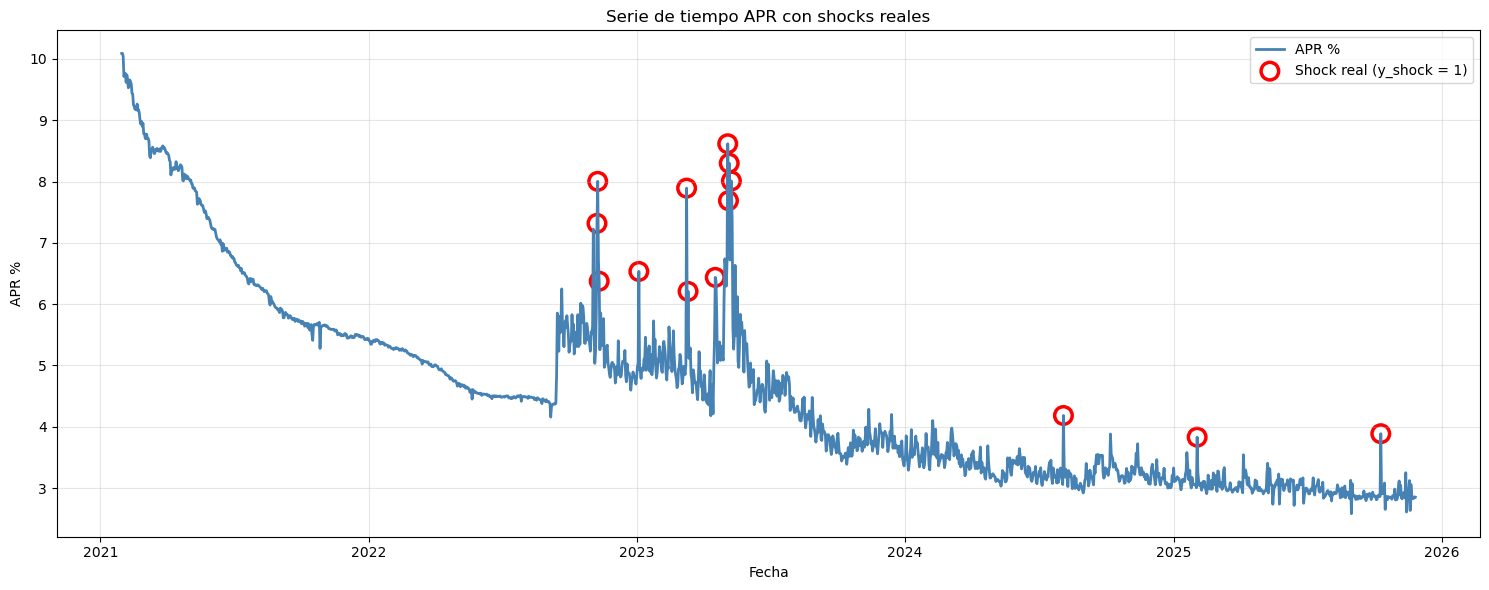

In [51]:
import matplotlib.pyplot as plt

plot_df = df.dropna(subset=["apr_pct", "y_shock"]).copy()

plt.figure(figsize=(15,6))

# Serie APR
plt.plot(
    plot_df["date"],
    plot_df["apr_pct"],
    color="steelblue",
    linewidth=2,
    label="APR %"
)

# Shocks reales 
shocks = plot_df[plot_df["y_shock"] == 1]

plt.scatter(
    shocks["date"],
    shocks["apr_pct"],
    s=160,
    facecolors="none",
    edgecolors="red",
    linewidths=2.5,
    label="Shock real (y_shock = 1)"
)

plt.title("Serie de tiempo APR con shocks reales")
plt.xlabel("Fecha")
plt.ylabel("APR %")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

RESULTADOS:
- Shocks < 1% de las semanas (Eventos extremadamente raros)
- En test: solo 2 eventos reales
- El modelo detecta 1 de ellos (recall 50%)
- Casi sin falsas alarmas
- Backtest: Equity igual a “always staking". El sistema de alerta no mejora retornos.